# OpenEO Connection to Google Earth Engine

In [1]:
import openeo
from openeo.internal.graph_building import PGNode
import json

In [2]:
# Define constants

# Connection
GEE_DRIVER_URL = "https://earthengine.openeo.org/v1.0"
OUTPUT_PATH = "/tmp/"
OUTFORMAT = "png"

**First, we need to connect to the backend by logging in with our username and password. In this example we use the basic authentication, alternatively OIDC authentication can be used.**

In [3]:
# Connect with GEE backend and authenticate with basic authentication
con = openeo.connect(GEE_DRIVER_URL)
con.authenticate_basic()

<Connection to 'https://earthengine.openeo.org/v1.0' with BearerAuth>

**Load the Sentinel-1 data for two polarisation (VV and VH) given a spatial and temporal boundary. It is the starting point of the process graph, by loading all input data needed for the workflow:**

In [4]:
# Select collection product to get a datacube object
datacube = con.load_collection("COPERNICUS/S1_GRD",
                               spatial_extent={"west": 16.06, "south": 48.1, "east": 16.65, "north": 48.31, "crs": "EPSG:4326"},
                               temporal_extent=["2017-03-01", "2017-04-01"],
                               bands=["VV", "VH"])

**Using the mean_time function, we can reduce the temporal dimension by calculating a statistical operation (e.g., mean). The result is a single image for each polarisation/band stored in one datacube.**

In [5]:
# Calculating mean value over time and reducing the time dimension. (resulting in one image per band)
datacube = datacube.mean_time()

**To split the data cube for each polarisation, the function "filter_bands" is called to create two data cubes, one only containing VV and one only containing VH data.
To formally align the polarisations with a colour channel name, the remaining band of the VV data cube is renamed to "R" and the  remaining band of the VH data cube to "G", respectively.**

In [6]:
# Red setting VV band as the red color of the resulting composite image.
red = datacube.filter_bands(["VV"])
red = red.rename_labels(dimension="bands", target=["R"])
# Linear scaling (just necessary because of png output format)
lin_scale = PGNode("linear_scale_range", arguments={"x": {"from_parameter": "x"},
                                                    "inputMin": -20, "inputMax": -5, "outputMin": 0, "outputMax": 255})

red = red.apply(lin_scale)

In [7]:
# Green setting VH band as the green color of the resulting composite image.
green = datacube.filter_bands(["VH"])
green = green.rename_labels(dimension="bands", target=["G"])
# Linear scaling (just necessary because of png output format)
lin_scale = PGNode("linear_scale_range", arguments={"x": {"from_parameter": "x"},
                                                    "inputMin": -26, "inputMax": -11, "outputMin": 0, "outputMax": 255})

green = green.apply(lin_scale)

**The reduce_dimension function now formulates a reduce operation over the spectral/bands dimension of the data cube, which allows to compute the cross-ratio with a substract operation in a callback.
Since the spectral dimension was reduced in the cross-ratio data cube, we have to add it again as a band dimension. In the same call, we can assign the label "B" to the single cross-ratio image.**

In [8]:
# Blue: Calculating difference of the two bands for the blue color of the resulting composite image
vh = PGNode("array_element", arguments={"data": {"from_parameter": "data"}, "label": "VH"})
vv = PGNode("array_element", arguments={"data": {"from_parameter": "data"}, "label": "VV"})
reducer = PGNode("subtract", arguments={"x": {"from_node": vh}, "y": {"from_node": vv}})

blue = datacube.reduce_dimension(dimension="bands", reducer=reducer)

blue = blue.add_dimension(name="bands", label="B", type="bands")
# Linear scaling (just necessary because of png output format)
lin_scale = PGNode("linear_scale_range", arguments={"x": {"from_parameter": "x"},
                                                    "inputMin": -5, "inputMax": 0, "outputMin": 0, "outputMax": 255})

blue = blue.apply(lin_scale)

**Now we merge all three images/datacubes into one datacube with the bands "R", "G" and "B" using two subsequent merge function calls.**

In [9]:
# Merging all color bands back into one datacube.
datacube = red.merge(green).merge(blue)

**In the last step we create the result image either by creating a GeoTiff or a PNG file. In the latter case, we need to define which band of the datacube should result in which RGB colour of the composite (using the "options" parameter).**

In [10]:
# Save resulting image as PNG, and also setting the connection to the PNG colors to the bands of the datacube.
datacube = datacube.save_result(format="PNG", options={"red": "R", "green": "G", "blue": "B"})

In [11]:
# Sending the job to the backend
job = datacube.send_job()
results = job.start_and_wait().download_results()
results

0:00:00.000001 Job 'Lu0LKtflDvTfrWtQ': running (progress N/A)
0:00:05.095782 Job 'Lu0LKtflDvTfrWtQ': finished (progress N/A)


{PosixPath('/data/REPO/openeo-python-client/examples/notebooks/8c0b423b061fa3c8.png'): {'href': 'https://earthengine.openeo.org/v1.0/storage/Lu0LKtflDvTfrWtQ/8c0b423b061fa3c8.png',
  'rel': 'data',
  'type': 'image/png'},
 PosixPath('/data/REPO/openeo-python-client/examples/notebooks/logs.db'): {'href': 'https://earthengine.openeo.org/v1.0/storage/Lu0LKtflDvTfrWtQ/logs.db',
  'rel': 'data',
  'type': 'application/octet-stream'}}

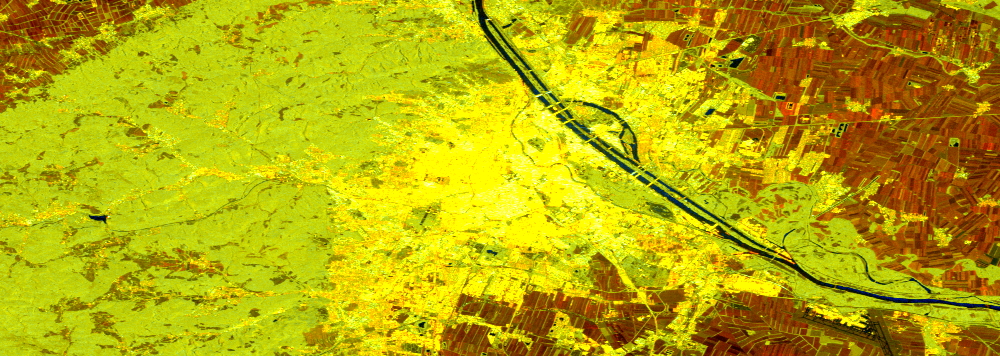

In [12]:
# Showing the result
from IPython.display import Image
for key, val in results.items():
    if ".png" in key.name:
        result = Image(filename=str(key))

result